# Imports

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import misc, ndimage
from scipy.stats import circmean
from scipy.optimize import least_squares
from itertools import product
from numpy.linalg import svd

from sklearn.ensemble import IsolationForest
from sklearn.linear_model import OrthogonalMatchingPursuit


# Functions

## Beta function extraction

### SVD

Phase space evolution turn-by-turn
$$x(N) = \sqrt{\epsilon\beta} \cos{\left(2\pi Q N\right)}$$
$$x'(N) = -\alpha\sqrt{\frac{\epsilon}{\beta}} \cos{\left(2\pi Q N\right)} + \sqrt{\frac{\epsilon}{\beta}}\sin{\left(2\pi Q N\right)}$$
or in matrix form
$$\pmatrix{x(N) \\ x'(N)} = \sqrt{\epsilon} \pmatrix{\sqrt{\beta} & 0 \\ \frac{-\alpha}{\sqrt{\beta}} & \frac{1}{\sqrt{\beta}} } \pmatrix{\cos{\left(2\pi Q N\right)} \\ \sin{\left(2\pi Q N\right)} }$$

In [9]:
def getbeta(x,px):
    """
    Get beta, alpha and ex from turn by turn data (x,px)
    """
    U, S, v = np.linalg.svd([x,px]) # SVD
    N = np.dot(U,np.diag(S))
    theta = np.arctan(-N[0,1]/N[0,0]) # rotation angle of matrix
    c = np.cos(theta)
    s = np.sin(theta)
    R = [[c,s],[-s,c]]
    X = np.dot(N,R) # Floquet up to 1/det(USR)
    betx = np.abs(X[0,0]/X[1,1])
    alfx = X[1,0] / X[1,1]
    ex = S[0] * S[1] / (len(x)/2.) # emit = det(S)/(n/2)
    return betx, alfx, ex

# AC dipole simulation

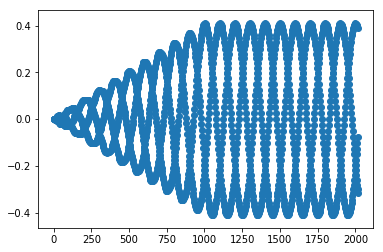

In [28]:
Q = .31
Qac = Q + 0.02
q =2 * np.pi *Q
R = np.array([[np.cos(q), -np.sin(q)],[np.sin(q),np.cos(q)]])
x=[[0.,0.]]
Nramp = 1000
Nturn = 2018

def ramp(j):
    return min(1, j*1.0/Nramp)

for i in range(Nturn):
    x.append(np.dot(R,x[-1]) + ramp(i) * np.array([0,0.1* np.cos(Qac*i*2*np.pi)]))
    
F = np.fft.fft(np.array(x)[Nramp:].T[0]) 

plt.scatter(range(Nturn+1),np.array(x)[:,0])

BPMs measure turn by turn transverse beam centroid position.
Need to excite the beam using single kick or resonant excitation.
$$X(N,s)=\sqrt{\beta_x(s)\epsilon_x} \cos{\left( 2 \pi Q N + \phi_x(s) \right)} + CO(s)$$

# Denoising data with SVD

In [150]:
# generating ideal (fake) BPM data
im = np.zeros((500,500))
for i in range(500):
    for j in range(500):
        im[i,j] = np.cos(i*0.0137*2*np.pi) * (np.cos(0.00678*j*2*np.pi)**2 + 1)
        
# adding noise
im = im + 0.2 * np.random.randn(*im.shape)

# denoising with svd
k=2
U,S,V = svd(im, full_matrices=False)
rim = np.dot(U[:,:k], np.dot(np.diag(S[:k]),V[:k,:]))

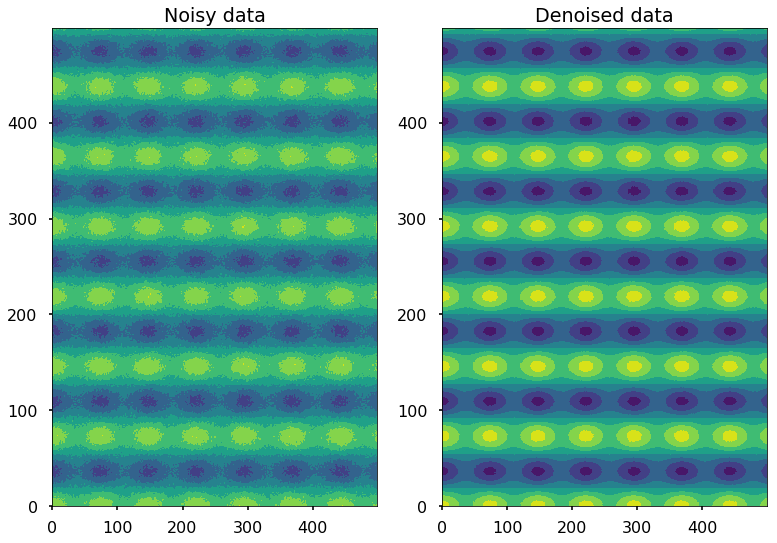

In [151]:
with plt.style.context('seaborn-poster'):
    gs = gridspec.GridSpec(1, 2)
    ax0 = plt.subplot(gs[0, 0])
    ax0.set_title('Noisy data')
    ax0.contourf(im)

    ax1 = plt.subplot(gs[0, 1])
    ax1.set_title('Denoised data')
    ax1.contourf(rim)
    plt.show()

# Isolation Forest (outlier detection)

In [77]:
N_turns = 500
N_bpms = 500

# generate bpm data with some bad signal - different tune, additional noise

bad_bpms_idx = [1,10,20,30,40]

im = np.zeros((N_turns,N_bpms))

for bpm in range(N_bpms):
    err = 0.05 *np.random.randn()
    amp = (np.cos(0.00678 * bpm *2 * np.pi)**2 +1) # sqrt (beta e)
    for turn in range(N_turns):
        if bpm in bad_bpms_idx:
            im[turn,bpm] = amp *np.cos(turn*(0.32+err)*2*np.pi) + 0.3 *np.random.randn()
        else:
            im[turn,bpm] = amp *np.cos(turn*(0.32+err/10)*2*np.pi) + 0.1 *np.random.randn()
            
# extract frequency and amplitude - features - from bpm signal
amplitudes = [np.max(x) for x in np.abs(np.fft.rfft(im.T))/N_turns]
frequencies = np.array([np.argmax(x) for x in np.abs(np.fft.rfft(im.T))])*1.0/N_turns

features = np.vstack((frequencies, amplitudes)).T

# fit isolation forest model to the data and detect anomalies (contamination is the fraction of anomalies)
iforest = IsolationForest(behaviour='new', n_estimators=10, contamination=0.01)
outlier_detection = iforest.fit(features).predict(features) # bad bpms = -1

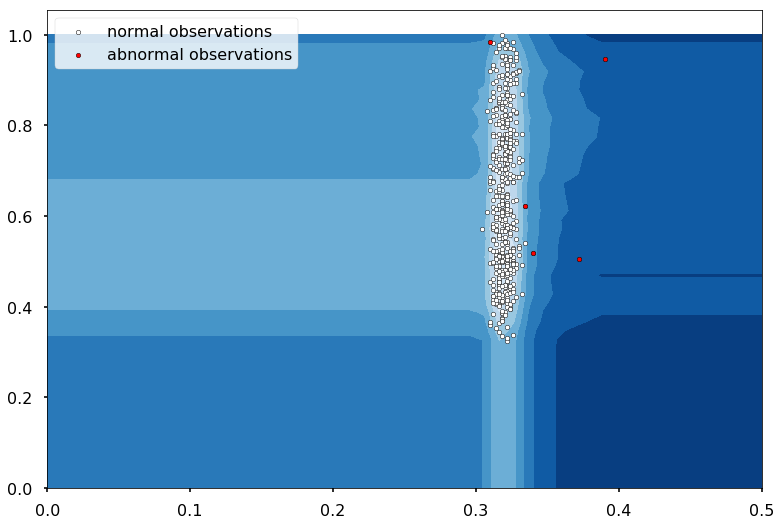

In [76]:
xx, yy = np.meshgrid(np.linspace(0, 0.5, 50), np.linspace(0, 1, 50))
Z = iforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

with plt.style.context('seaborn-poster'):
    # plot the IF decision function
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

    # plot the data points
    b1 = plt.scatter(features[:, 0], features[:, 1], c='white',
                 s=20, edgecolor='k')

    c = plt.scatter(features[np.where(outlier_detection==-1)][:, 0], features[np.where(outlier_detection==-1)][:, 1], c='red',
                s=20, edgecolor='k')
    plt.axis('tight')

    plt.legend([b1, c],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
    plt.show()

# Harpy

Frequency interpolation method

In [126]:
PI2I = 2 * np.pi * complex(0,1)
def jacobsen(dft, n): # interpolation to find dominant freq
    k = np.argmax(np.abs(dft))
    delta = np.tan(np.pi / n) / (np.pi/n)
    kp = (k+1) % n
    km = (k-1) % n
    delta = delta * np.real((dft[km]-dft[kp]) / (2*dft[k]-dft[km]- dft[kp]))
    return (k + delta) / n
    
def harpy(samples, num_harmonics):
    n = len(samples)
    int_range = np.arange(n)
    
    coeffs = []
    freqs = []
    
    for _ in range(num_harmonics):
        freq = jacobsen(np.fft.fft(samples),n)
        exponents = np.exp(-PI2I * freq * np.arange(n))
        coeff = np.sum(exponents*samples)/n
        coeffs.append(coeff)
        freqs.append(freq)
        new_signal = coeff * np.exp(PI2I * freq * int_range)
        samples = samples - new_signal # remove dominant freq
    coeffs, freqs = zip(*sorted(zip(coeffs, freqs),key=lambda tuple: np.abs(tuple[1]), reverse=True))
    return freqs, coeffs

N = 4096
i= 2 * np.pi * np.arange(N)
data = np.cos(0.134 * i) + np.cos(0.244 * i) + 0.01 * np.random.randn(4096)
freqs, coeffs = harpy(data,300)
data_zeropad = np.pad(data, (0,9*N), 'constant')
f_zeropad = np.abs(np.fft.fft(data_zeropad)/N)

(0.133, 0.1355)

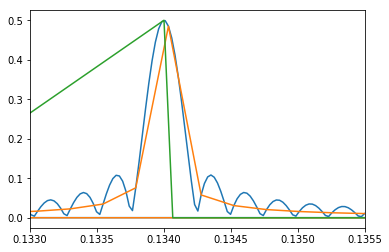

In [147]:
plt.plot(np.fft.fftfreq(data_zeropad.shape[-1]),f_zeropad)
plt.plot(np.fft.fftfreq(i.shape[-1]),np.abs(np.fft.fft(data))/N)
plt.plot(freqs,np.abs(coeffs))
plt.xlim(0.133,0.1355)

# Farey Sequences

In [165]:
from fractions import Fraction
 
 
class Fr(Fraction):
    def __repr__(self):
        return '(%s/%s)' % (self.numerator, self.denominator)
 
 
def farey(n, length=False):
    if not length:
        return [Fr(0, 1)] + sorted({Fr(m, k) for k in range(1, n+1) for m in range(1, k+1)})
    else:
        #return 1         +    len({Fr(m, k) for k in range(1, n+1) for m in range(1, k+1)})
        return  (n*(n+3))//2 - sum(farey(n//k, True) for k in range(2, n+1))
 
def Farey(n):
    def gcd(a,b):
        while b: a,b = b,a%b
        return a

    def simplify(a,b):
        g = gcd(a,b)
        return (a/g,b/g)

    fs = dict()
    for i in range(1,n+1):
        for i2 in range(1,i+1):
            if i2 < n and i != i2:
                r = simplify(i2,i)
                fs[float(i2)/i] = r

    return [fs[k] for k in sorted(fs.keys())]

In [166]:
Farey(5)

[(1.0, 5.0),
 (1.0, 4.0),
 (1.0, 3.0),
 (2.0, 5.0),
 (1.0, 2.0),
 (3.0, 5.0),
 (2.0, 3.0),
 (3.0, 4.0),
 (4.0, 5.0)]

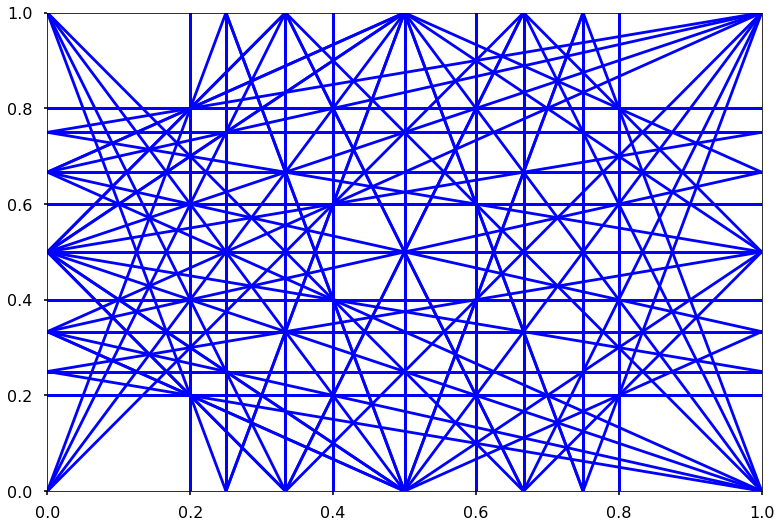

In [169]:
with plt.style.context('seaborn-poster'):
    fig = plt.figure()
    ax = plt.axes()
    plt.ylim((0,1))
    plt.xlim((0,1))
    x= np.linspace(0,1,1000)
    FN = Farey(5)
    for f in FN:
        h,k =f
        for sf in FN:
            p,q=sf
            c = float(p*h)
            a = float(k*p)
            b = float(q-k*p)
            if a>0:
                plt.plot(x, c/a-x*b/a, color='blue')
                plt.plot(x, c/a+x*b/a, color='blue')
                plt.plot(c/a-x*b/a, x, color='blue')
                plt.plot(c/a+x*b/a, x, color='blue')
                plt.plot(c/a-x*b/a, 1-x, color='blue')
                plt.plot(c/a+x*b/a, 1-x, color='blue')
            if q==k and p==1:
                break
    plt.show()
                

# Best N correctors

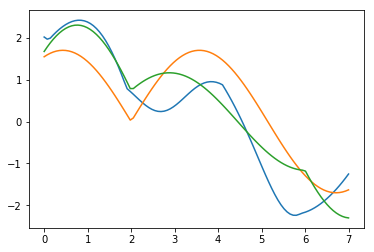

In [175]:
N_corrs=7
s=np.linspace(0,N_corrs,100) # number of observation points

def corrs(x,i): # assume correctors at i=integer > N_corrs
    return np.sin(np.abs(x-i))

def model(x,c):
    if len(x) ==1:
        return sum(c*corrs(x,np.arange(N_corrs)))
    else:
        return [model([y],c) for y in x]
    
def measured_orbit(x): # target orbit
    return np.sin(np.abs(x-0.1)) + np.sin(np.abs(x-1.9)) - np.sin(np.abs(x-4.1) -np.sin(np.abs(x-5.9)))

def f(c): # figure of merit fro given corrector choice encoded in mask
    return model(s,c*mask) - measured_orbit(s)

best = 1e16*np.ones(N_corrs+1)
bestmask = np.zeros([N_corrs+1,N_corrs])

for mask in product([0,1], repeat=N_corrs): # try all corr combinations
    res = least_squares(f, x0=np.ones(N_corrs))
    if res.cost < best[sum(mask)]:
        bestmask[sum(mask)]= mask *res.x
        best[sum(mask)] = res.cost
        
plt.plot(s,measured_orbit(s))
plt.plot(s, model(s, bestmask[1]))
plt.plot(s, model(s, bestmask[2]))

[0.         0.         1.91048689 0.         0.         0.
 0.        ]


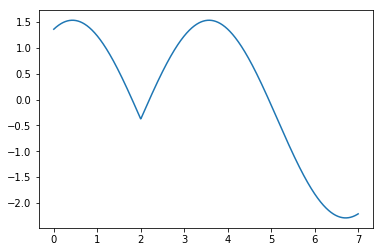

In [177]:
N_corrs =7
N_bpms = 1000
s=np.linspace(0, N_corrs, N_bpms)

X =[]
for i in range(N_bpms):
    X.append(corrs(s[i],np.arange(N_corrs)))

y = measured_orbit(s)
reg = OrthogonalMatchingPursuit(n_nonzero_coefs=1).fit(X,y)

print(reg.coef_)
plt.plot(s,reg.predict(X))

# Tests

## Beta Function Extraction

### SVD 

In [10]:
# generate data to test on
alpha = 0.2
beta = 1.
ex = 2e-3
Q=0.31
Nturns = 600
x = np.sqrt(beta*ex)*np.cos(2*np.pi*Q*np.arange(0,Nturns)) # easy tracking
px = - alpha * x/beta + np.sqrt(ex/beta)*np.sin(2*np.pi*Q*np.arange(0,Nturns))

betx, alfx, exc = getbeta(x,px)

print('Beta  : ',betx)
print('Alpha : ',alfx)
print('ex    : ',ex)

0.6710053207609474
Beta  :  0.9999999999999996
Alpha :  0.19999999999999965
ex    :  0.002


## Farey

In [158]:
for _ in range(6):
    print(farey(_))

[(0/1)]
[(0/1), (1/1)]
[(0/1), (1/2), (1/1)]
[(0/1), (1/3), (1/2), (2/3), (1/1)]
[(0/1), (1/4), (1/3), (1/2), (2/3), (3/4), (1/1)]
[(0/1), (1/5), (1/4), (1/3), (2/5), (1/2), (3/5), (2/3), (3/4), (4/5), (1/1)]
